# Plots for paper

In [5]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
import sys
try:
    sys.path.remove("../py_src") # Hacky way to add higher directory to python modules path. 
except:
    pass
sys.path.append("../py_src") # Means that I dont have to make src/ a proper python package

In [13]:

import matplotlib.pyplot as plt 

import numpy as np 
import json
import pandas as pd 
import corner
import scienceplots


def load_data_and_check_for_weird_values(path):



 # Opening JSON file
    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 



    extra_median = df_posterior['psi_gw'].median()
    if extra_median < 1.0: #psi is weird / not converged so don't plot it 
        #print("Ignoring this file since psi not converged",extra_median)
        return_code = 1
    else:
        return_code = 0

    return return_code


def load_data(path,variables_to_plot):

    f = open(path)
    data = json.load(f)
    f.close()
    #Make it a dataframe. 
    df_posterior = pd.DataFrame(data["posterior"]["content"]) 
 
    return df_posterior[variables_to_plot]

In [10]:
import glob 
#list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/compressed_files/*shifted_prior*.parquet.gzip"))
list_of_files = sorted(glob.glob("../data/nested_sampling/data_for_manuscript/small_h_batch/*"))

parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h",]

list_of_well_behaved_files = []

for f in list_of_files:
    return_code = load_data_and_check_for_weird_values(f)

    if return_code == 0:
        list_of_well_behaved_files.extend([f])


#f = list_of_files[1]
#df_reference,return_code = load_data(f,parameters)

In [11]:
len(list_of_well_behaved_files) / len(list_of_files)

0.9

In [45]:
#Process all files 


parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h",]



all_arrays = []
for f in list_of_well_behaved_files:

    print(i)

    df = load_data(f,parameters)

    numpy_array = df.to_numpy()

    all_arrays.extend([numpy_array])

    i+=1

print("saving")
numpyify = np.array(all_arrays, dtype=object)
outfile = '../data/pairwise_wasserstein'
np.save(outfile, numpyify)



89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
saving


In [1]:
import numpy as np 
new_data = np.load('../data/pairwise_wasserstein.npy',allow_pickle=True)

In [2]:
import itertools
indexes = list(itertools.combinations(range(len(new_data)), 2))

In [5]:
from scipy.stats import wasserstein_distance
parameters = ["omega_gw","phi0_gw","psi_gw","iota_gw","delta_gw","alpha_gw","h"]
wasserstein_results = np.zeros((len(indexes),len(parameters)))
i=0
for a,b in indexes:

    data1 = new_data[a]
    data2 = new_data[b]

    for p in range(len(parameters)):
        data1_slice = data1[:,p]
        data2_slice = data2[:,p]


        w = wasserstein_distance(data1_slice,data2_slice)
        wasserstein_results[i,p] += w 


    i +=1

In [100]:
np.log10(5e-7)

-6.301029995663981

In [6]:
print(np.median(wasserstein_results,axis=0))
parameter_scales = [5e-6,2*np.pi,2*np.pi,2*np.pi,2*np.pi,2*np.pi,1e-9]
print("Percentage medians:", 100.0*np.median(wasserstein_results,axis=0) / parameter_scales)

[1.03772738e-09 1.34206317e-01 1.69199228e-01 1.40567641e-01
 9.31052587e-02 1.68504543e-01 8.14104117e-16]
Percentage medians: [2.07545477e-02 2.13595988e+00 2.69288935e+00 2.23720348e+00
 1.48181621e+00 2.68183310e+00 8.14104117e-05]


In [92]:
from matplotlib import ticker, cm
import matplotlib.pyplot as plt 
import seaborn as sns 
import scienceplots





plt.style.use('seaborn')



def plot_wasserstein_pairs(data,idx,use_axes_limits=True,title='$\Omega$'):

    #Get the data
    data_slice = data[:,idx]

    #Make it a 2D numpy array
    size_X = 90
    X = np.zeros((size_X,size_X))
    X[np.triu_indices(X.shape[0], k = 1)] = data_slice
    X = X + X.T
    
    #Create a mask since symmetric
    mask = np.zeros_like(X, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    cmap = 'viridis' 


    #Setup figure
    fig = plt.figure(figsize=(6,6))
    ax = fig.add_subplot(111)


    if use_axes_limits:
        vmax=np.max(X)
    else:
        vmax = 0.50

    
    sns.heatmap(X, mask=mask, cmap=cmap, vmax=vmax, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9},ax=ax)
    #ax.figure.axes[-1].yaxis.label.set_size(20)


    #ax.figure.axes[-1].set_title('dfdfdff')

    cbar = ax.collections[0].colorbar
    cbar.set_label('$W_1$', labelpad=20,rotation=0,fontsize=20)
    cbar.ax.tick_params(labelsize=fs-4) 
    #cbar.label.set_size(20)


    #ax.figure.axes[0].set_major_locator(plt.MaxNLocator(20))

    plt.gca().axes.xaxis.set_ticklabels([])
    plt.gca().axes.yaxis.set_ticklabels([])


    #ax.set_title(title)  
    outfile = f'WD_{idx}'
    plt.savefig(f"../data/images/{outfile}.png", bbox_inches="tight",dpi=300)

    plt.savefig('')
    plt.show()


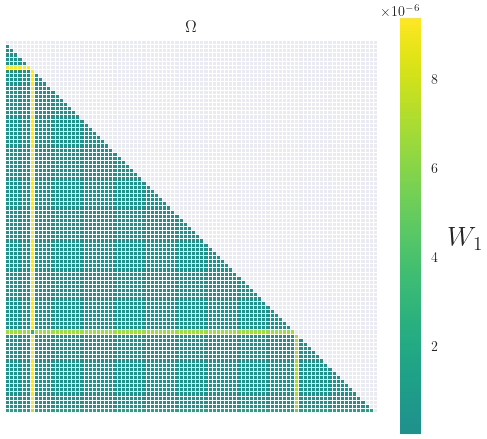

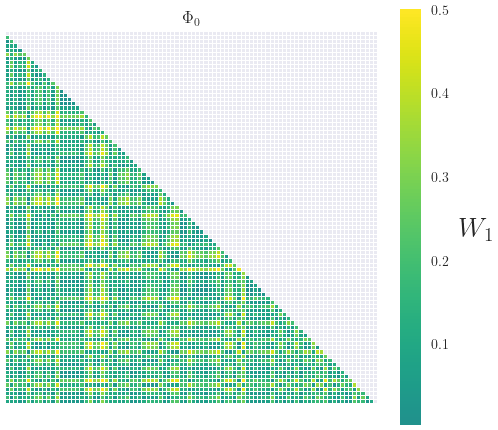

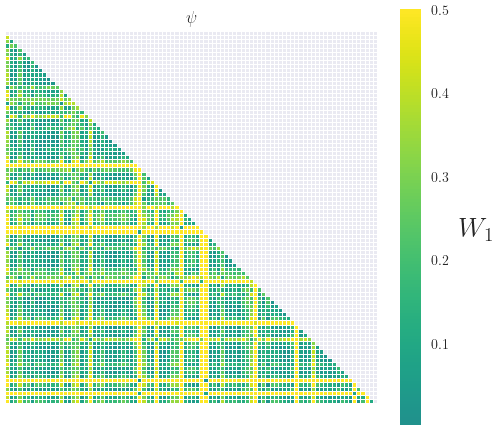

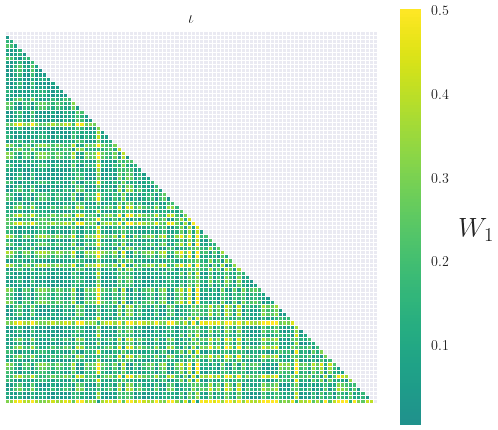

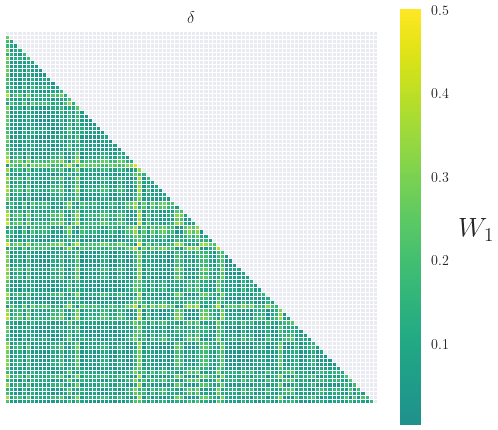

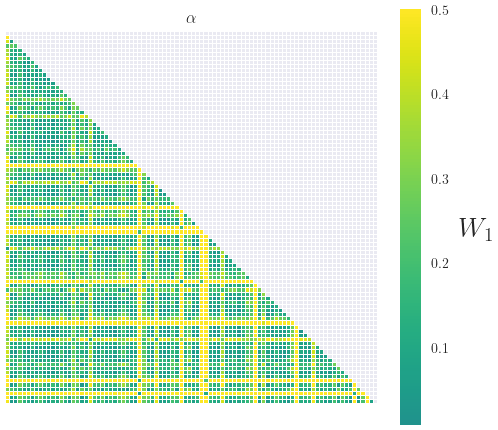

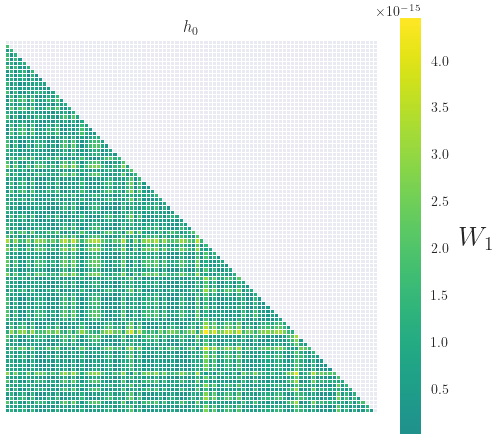

In [97]:
labels = ['$\Omega$','$\Phi_0$','$\psi$','$\iota$', '$\delta$','$\\alpha$','$h_0$']
#labels = ['$\Omega$','$\Omega$','$\Omega$','$\Omega$','$\Omega$','$\Omega$','$\Omega$']
use_axes_limits = [True,False,False,False,False,False,True]
for i in range(len(parameters)):
    plot_wasserstein_pairs(wasserstein_results,i,use_axes_limits=use_axes_limits[i],title=labels[i])

In [21]:
wasserstein_results[:,1]

array([0.18579347, 0.00529874, 0.08418764, ..., 0.10126136, 0.02843275,
       0.0953237 ])

In [106]:
wasserstein_results.shape

(4005, 7)

In [109]:
wasserstein_results[:,3]

array([0.0378577 , 0.15433196, 0.22777011, ..., 0.03917736, 0.41657718,
       0.39991208])

In [85]:
phi0_wasser = wasserstein_results[:,1]

In [86]:
phi0_wasser.shape

(4005,)

In [ ]:
phi0_wasser_reshaped = phi0_wasser.reshape()

In [121]:
np.min(phi0_wasser)

0.0031327035398833057

0.5791704394959557
0.0


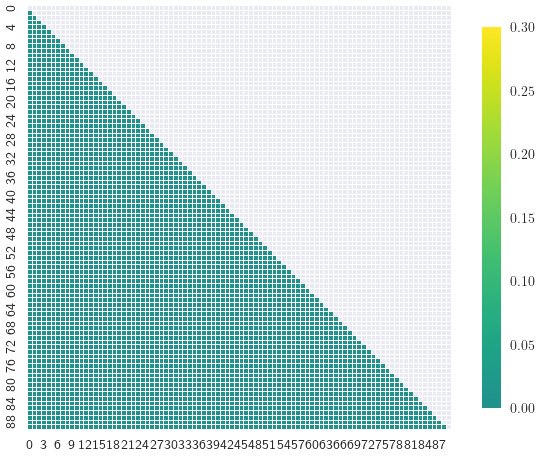

In [127]:
plt.style.use('seaborn')

#Get the data
phi0_wasser = wasserstein_results[:,1]

#Make it a 2D numpy array
size_X = 90
X = np.zeros((size_X,size_X))
X[np.triu_indices(X.shape[0], k = 1)] = phi0_wasser


#Create a mask since symmetric
mask = np.zeros_like(X, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = 'viridis' 

print(np.max(X))
print(np.min(X))



ax = sns.heatmap(X, mask=mask, cmap=cmap,vmin=0.0,vmax=0.30, center=0,
        square=True, linewidths=.5, cbar_kws={"shrink": .9})

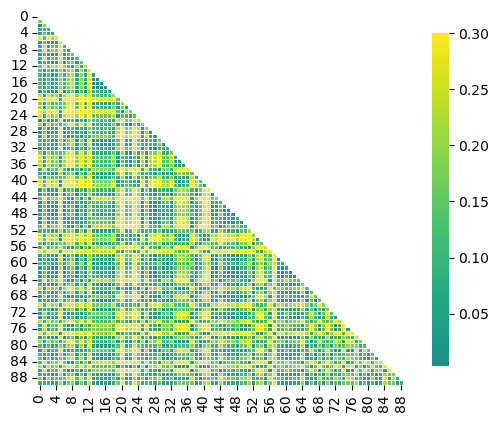

In [100]:

mask = np.zeros_like(X, dtype=bool)
mask[np.triu_indices_from(mask)] = True

cmap = 'viridis' 

ax = sns.heatmap(X, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .9})


In [88]:
len(indexes)

4005

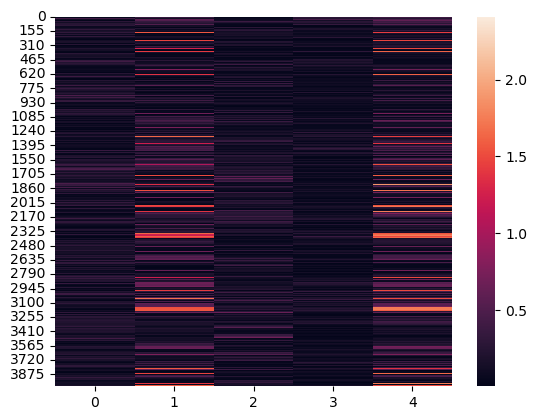

In [80]:

import seaborn as sns
import matplotlib.pylab as plt

ax = sns.heatmap(angular_wassersteins)
plt.show()



In [ ]:
def process_files():

    #Load pandas df
   


    #Make it a np array
    numpy_array = df.to_numpy()

    #Save to file

In [14]:
f = list_of_well_behaved_files[0]
df_reference = load_data(f,parameters)

In [17]:
import sys 
from scipy.stats import wasserstein_distance


wasserstein_results = np.zeros((len(list_of_well_behaved_files)-1,len(parameters)))
for i in range(1,len(list_of_well_behaved_files)):
    print(len(list_of_well_behaved_files) - i)
    f = list_of_well_behaved_files[i]
    df = load_data(f,parameters)
    k = 0
    for p in parameters:
    
        w = wasserstein_distance(df_reference[p].to_numpy(),df[p].to_numpy())
        wasserstein_results[i-1,k] += w 
        k += 1


    

89
88
87
86
85
84
83
82
81
80
79
78
77
76
75
74
73
72
71
70
69
68
67
66
65
64
63
62
61
60
59
58
57
56
55
54
53
52
51
50
49
48
47
46
45
44
43
42
41
40
39
38
37
36
35
34
33
32
31
30
29
28
27
26
25
24
23
22
21
20
19
18
17
16
15
14
13
12
11
10
9
8
7
6
5
4
3
2
1


In [18]:
wasserstein_results

array([[2.33762205e-09, 1.85793466e-01, 4.17163916e-01, 3.78576986e-02,
        2.72200288e-01, 4.95478257e-01, 1.80396929e-15],
       [3.33474481e-09, 5.29873931e-03, 3.29721354e-01, 1.54331957e-01,
        1.88488160e-01, 4.39366731e-01, 3.96422191e-16],
       [2.87603511e-09, 8.41876446e-02, 1.20435261e-01, 2.27770106e-01,
        1.67126081e-01, 2.32860026e-01, 1.59092618e-15],
       [1.87317742e-09, 5.22695443e-02, 3.34526571e-01, 8.30884199e-02,
        3.00919846e-01, 3.72490521e-01, 1.79944499e-15],
       [3.77517993e-09, 3.19794047e-01, 2.85595568e-01, 7.61286989e-02,
        1.29696686e-01, 3.70372983e-01, 5.81118317e-16],
       [9.36614904e-06, 3.69796665e-02, 4.54768595e-01, 2.42415977e-01,
        3.14875043e-01, 4.65051655e-01, 1.88822500e-15],
       [1.33088207e-09, 7.12594361e-02, 2.89649182e-01, 6.80122336e-02,
        2.30735287e-01, 3.61292269e-01, 4.44071591e-16],
       [1.05317124e-09, 1.04630016e-01, 3.01233160e-01, 3.01081922e-02,
        2.55854264e-01, 3

array([1.85106425e-09, 1.04630016e-01, 3.67648143e-01, 1.20051528e-01,
       2.58112801e-01, 3.97526468e-01, 1.12204622e-15])

In [20]:
np.median(wasserstein_results,axis=0)
injection_parameters = [5e-7,0.20,2.50,1.0,1.0,1.0,5e-15]
np.median(wasserstein_results,axis=0) / injection_parameters


array([0.00370213, 0.52315008, 0.14705926, 0.12005153, 0.2581128 ,
       0.39752647, 0.22440924])

In [38]:
df = load_data(f,parameters)

In [39]:
df

,omega_gw,phi0_gw,psi_gw,iota_gw,delta_gw,alpha_gw,h
0,5.000001e-07,0.193300,2.595132,0.758582,1.001830,1.038984,1.062884e-12
1,4.999990e-07,0.195338,2.594946,0.914982,1.001852,1.038783,1.183517e-12
2,5.000085e-07,0.195745,2.596255,0.743157,1.002767,1.039714,1.052433e-12
3,5.000015e-07,0.195423,2.596508,0.827010,1.002305,1.039820,1.114980e-12
4,4.999917e-07,0.192893,2.595399,0.968847,1.001697,1.039041,1.229464e-12
...,...,...,...,...,...,...,...
11605,5.000000e-07,0.194168,2.595424,1.013730,1.001215,1.038944,1.270089e-12
11606,4.999969e-07,0.193350,2.596211,0.977245,1.002433,1.039815,1.236280e-12
11607,4.999981e-07,0.193549,2.596407,0.939210,1.002701,1.039909,1.204758e-12
11608,4.999961e-07,0.194011,2.595116,0.887927,1.001503,1.039113,1.161320e-12


In [ ]:
ws_df = df.groupby('grp').apply(lambda x: stats.wasserstein_distance(x['p'], x['q']))


In [17]:
from scipy.stats import wasserstein_distance

var = "h"
wasserstein_distance(df_reference[var].to_numpy(),df[var].to_numpy())



1.1943624520184697e-13